# Practical extreme value analysis applied to precipitation

 In order to get more reliable estimates of extremes with higher return periods we use extreme value analysis (EVA). 

In EVA, the first step is to filter your data for which we can distinguish three main methods: 
- Block Maxima (BM), where the block is taken usually taken as 1 year (thus, annual maxima, AM);
- Peaks over Threshold (POT) method, which uses all events above a certain threshold;
- Recently developed method called the Metatistatistical Extreme Value (MEV) method, which uses all rainy days in a block to infer block maxima. 

As a second step, we consequently have to assume that our 'observed' values to belong to a statistical distribution. In this class we will work with AM (Gumbel and GEV) and the MEV method. We skip the POT methods as usually the results are quite similar to GEV, especially for large return periods. 




In [29]:
# import necessary packages
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import mevpy as mev # only works when this folder is in the folder of this .ipnyb-file
import warnings
import random
warnings.simplefilter('ignore') # filter some warning messages

### 1.1	Definitions
Different symbols are being used in various literature sources. Here, we stick to the following definitions:
- $c$ = number of events in interval t
- $d$ = length of the record (in days)
- $F(x)$ = cumulative distribution function of the variable x (This is the same as the probability of non-exceedance)
- $i$ = ranking of annual extremes 
- $k$ = duration (in days)
- $M$ = length of the record (in years) 
- $n_\text{occ}$ = number of times that an event within the class occurs
- $n_\text{ex}$ = number of times that the bottom of the class is being exceeded
- $P()$ = probability in a general sense, between brackets we specify which probability we want to express.
- $p$ = annual probability of exceedance of a certain precipitation event
- $q$ = annual probability of non-exceedance of a certain precipitation event
- $R$ = rainfall/precipitation (usually we use $P$, but now $R$ to avoid the confusion with probability)
- $R_\text{max}$ = maximum precipitation in a block
- $r$ = rate of occurrence (1/time)
- $s$ = standard deviation
- $T$ = Return period (a frequency scale) of exceeding a certain precipitation event (1/year)
- $T_a$ = return period of annual extremes (1/year)
- $x$ = general variable to be estimated
- $t$ = time interval
- $\mu$ = location parameter (not necessarily the mean!)
- $\sigma$ = scale parameter (not necessarily the standard deviation!)
- $\xi$ = shape parameter
- $y$ = reduced variate
- $N$ = Number of wet days per year (used in MEV-Weibull)
- $C$ = scale parameter of the (MEV-)Weibull distribution (not necessarily the standard deviation!)
- $W$ = shape parameter of the (MEV-)Weibull distribution
- $\zeta(x)$ = cumulative distribution function of the variable x for MEV-Weibull
- $H(x)$ = cumulative distribution function of the variable x for in individual year with Weibull fitted through the wet days

### 1.2 Data pre-processing
In this exercise we use the Multi-Source Weighted-Ensemble Precipitation version 2 (MSWEP v2) data set (Beck et al., 2018). The data provide daily precipitation values on 0.1° latitude × 0.1° longitude for the period 1979-2017. The data can be found on Brightspace. You can choose from different locations for your analysis. 

Make sure your csv file is in the same folder as this python notebook. Use pandas to create a dataframe of the csv file, and set the column 'time' as the datetime-index of the dataframe.

In [30]:

import xarray as xr
# insert the filename
filename = "OBS6_ERA5_reanaly_1_day_pr_2000-2018_newbasin.nc"  # Update the path to the correct location of the file
# Read the NetCDF file
ds = xr.open_dataset(filename)
# Convert to a pandas DataFrame
df = ds.to_dataframe()
# Reset the index if needed
df.reset_index(inplace=True)
df = df[df['bnds'] == 0]
df.index = pd.to_datetime(df['time'])
df.index = df.index.normalize() # Ensure the index is a DatetimeIndex
df.drop(columns=['time', 'bnds'], inplace=True)
# Extract the precipitation data
prec = df['pr'] * 86400  # Convert from m/s to mm/day
prec[prec < 0] = np.nan  # Set negative values to NaN
prec = prec.dropna()

# Rename the series for clarity
prec.name = 'PRCP'
prec = prec.to_frame(name='PRCP')
prec['YEAR'] = prec.index.year



Look into the first 10 lines.

In [31]:
# exercise, inspect the first ten lines of the data

prec.tail(10)


,PRCP,YEAR
time,,
2018-12-19,1.064198,2018
2018-12-20,0.278718,2018
2018-12-21,0.000839,2018
2018-12-22,0.000113,2018
2018-12-23,0.001196,2018
2018-12-25,0.000039,2018
2018-12-27,0.000153,2018
2018-12-28,0.043055,2018
2018-12-29,0.054359,2018


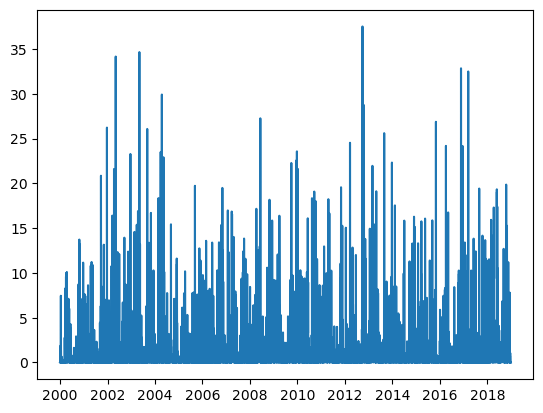

In [32]:
plt.plot( prec.index, prec['PRCP'])

## 2 Gumbel
The fundamental Gumbel-theorem can be stated as: if $x_1$, $x_2$, $x_3$, ... $x_n$ are independent extreme values observed in $n$ samples of equal size $N$ (e.g., years), and if $x$ is an unlimited exponentially-distributed variable, then as $n$ and $N$ approach infinity, the cumulative probability that any of the extremes will be less than a given value $x_i$ is given by:

$F(x;\mu ,\sigma )=q=\exp \left( -\exp (-\frac{x-\mu }{\sigma }) \right)$

Where the reduced variate is defined by:

$y=\frac{x-\mu }{\sigma }=-\ln \left( -\ln (q) \right)$ 

In [33]:
# Here is an adapted function to sample annual maxima from CEGM1400 that you may use
def annual_maxima(data):
    idx_max = data.groupby(data.index.year)['PRCP'].idxmax()
    max_list = data.loc[idx_max]
    return max_list

In [34]:
# exercise: call the annual maxima function and store your data show your list of annual maxima
R_max = annual_maxima(prec)
R_max.head(19)

,PRCP,YEAR
time,,
2000-10-24,13.722207,2000
2001-12-23,26.224214,2001
2002-05-07,34.157177,2002
2003-05-06,34.655520,2003
2004-04-16,29.915765,2004
2005-09-07,19.726399,2005
2006-11-03,19.491050,2006
2007-01-26,16.975480,2007
2008-06-09,27.260187,2008


In [35]:
# exercise: write a code to sort your annual maxima from highest to lowest rainfall and store in a new dataframe
# tip: use pandas.DataFrame.sort_values

R_max_sorted = R_max.sort_values(by = 'PRCP' , ascending = False)
R_max_sorted.head()

,PRCP,YEAR
time,,
2012-09-28,37.516056,2012
2003-05-06,34.655520,2003
2002-05-07,34.157177,2002
2016-11-22,32.844340,2016
2017-03-13,32.490877,2017


- $M$ = length of the record (in years) 
- $i$ = ranking of annual extremes 
- $p = \frac{i}{M+1}$
- $p$ = annual probability of exceedance of a certain precipitation event
- $q$ = annual probability of non-exceedance of a certain precipitation event
- $y$ = reduced variate
- $T_a$ = return period of annual extremes (1/year)

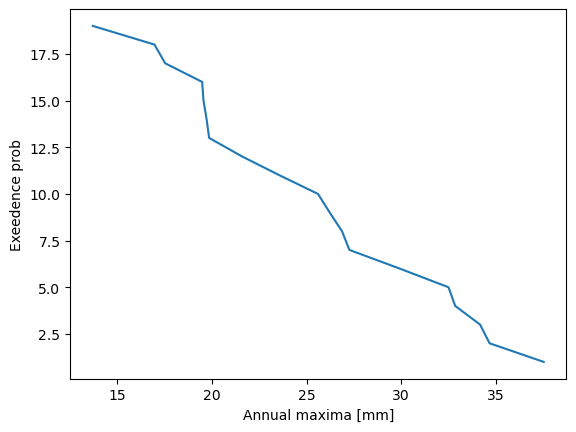

In [36]:
#exercise, calculate N and expand you annual maxima dataframe with the columns i, p, q, q, T_a
M = len(R_max_sorted)
R_max_sorted['i'] = np.arange(1,M+1,1)
R_max_sorted['p'] = R_max_sorted['i']/(M+1)

plt.plot(R_max_sorted['PRCP'] , R_max_sorted['i'])
plt.ylabel('Exeedence prob')
plt.xlabel('Annual maxima [mm]')
plt.show()

R_max_sorted['q'] = 1 - R_max_sorted['p']
R_max_sorted['y'] = -np.log(-np.log(R_max_sorted['q']))
R_max_sorted['T_a'] = 1/R_max_sorted['p']


In [37]:
R_max_sorted.head(20)

,PRCP,YEAR,i,p,q,y,T_a
time,,,,,,,
2012-09-28,37.516056,2012,1,0.05,0.95,2.970195,20.000000
2003-05-06,34.655520,2003,2,0.10,0.90,2.250367,10.000000
2002-05-07,34.157177,2002,3,0.15,0.85,1.816961,6.666667
2016-11-22,32.844340,2016,4,0.20,0.80,1.499940,5.000000
2017-03-13,32.490877,2017,5,0.25,0.75,1.245899,4.000000
2004-04-16,29.915765,2004,6,0.30,0.70,1.030930,3.333333
2008-06-09,27.260187,2008,7,0.35,0.65,0.842151,2.857143
2015-11-02,26.873122,2015,8,0.40,0.60,0.671727,2.500000
2001-12-23,26.224214,2001,9,0.45,0.55,0.514437,2.222222


According to the theory of Gumbel these observations should plot on a straight line against the reduced variate. My data is all stored in `annual_maxima_df_sorted`, but this may of course have a different name in your code.
Let's have a look at the reduced variate vs annual maxima precipitation:

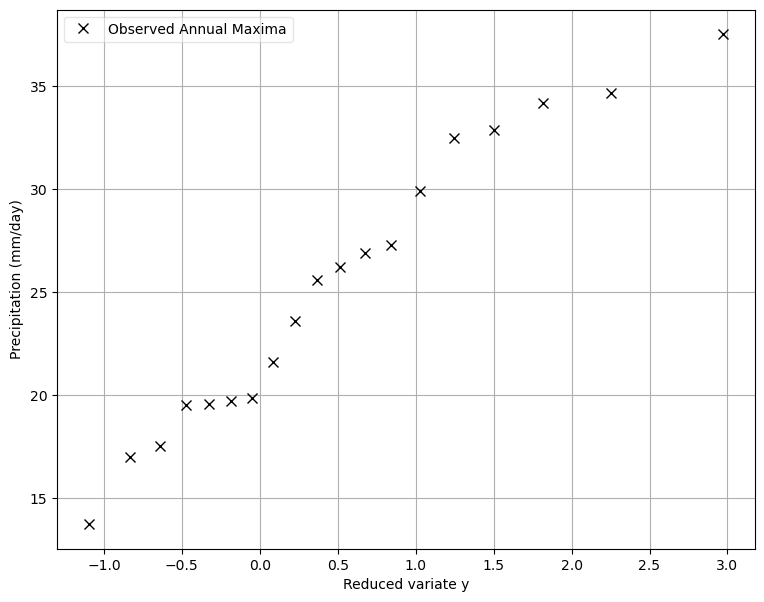

In [38]:
# exercise: plot the reduced variate y against the annual maxima
# change the name of the dataframe in the code below to what you used, 
# or rename your own dataframe to get this code running
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(R_max_sorted['y'].values, R_max_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima') 
ax.set_xlabel('Reduced variate y')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

Now we fit a straight line from which we can obtain the parameters $\mu$ and $\sigma$ of the Gumbel distribution.
${{R}_{\text{Gumbel} }}=\sigma y+\mu $

$\sigma =\frac{{{s}_{R}}}{{{s}_{y}}}$

$\mu =\overline{{{R}_{\max }}}-{{s}_{R}}\frac{\overline{y}}{{{s}_{y}}}$

Where $s_y$ and $s_R$ are the standard deviation of the reduced variate and the sample respectively.


In [39]:
# exercise: compute Gumbel parameters (name them sigma and mu)
s_R = R_max_sorted['PRCP'].std()
s_y = R_max_sorted['y'].std()
y_gem = R_max_sorted['y'].mean()
R_max_gem = R_max_sorted['PRCP'].mean()



sigma = s_R/s_y
mu = R_max_gem - s_R*(y_gem/s_y)



print('scale parameter σ = ' + str(sigma))
print('location parameter µ = ' + str(mu))

scale parameter σ = 6.371978335192904
location parameter µ = 21.91745162839651


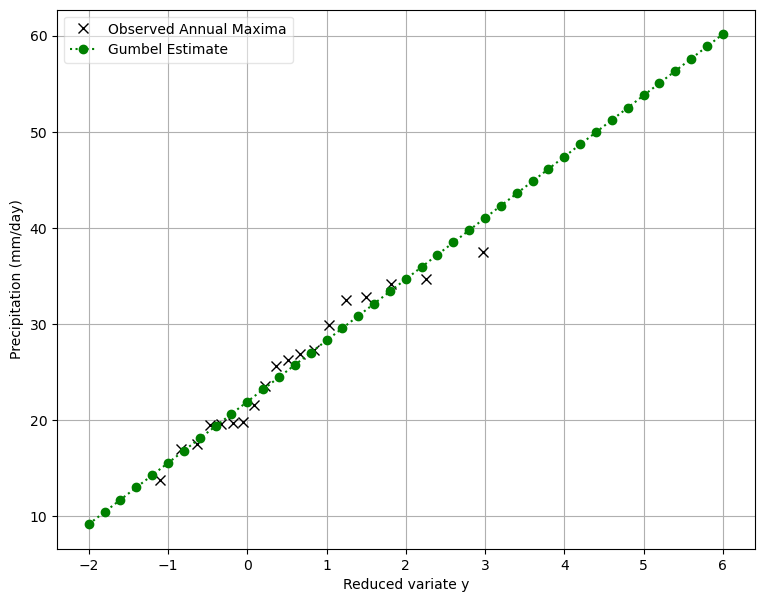

In [40]:
# Now we can construct the Gumbel fit and plot the Gumbel line
dummy_y = np.arange(-2,6.01,0.2)
R_Gumbel = sigma * dummy_y + mu

fig, ax = plt.subplots(figsize=(9,7))
ax.plot(R_max_sorted['y'].values, R_max_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(dummy_y, R_Gumbel, \
        ':og', label = 'Gumbel Estimate')
ax.set_xlabel('Reduced variate y')
ax.set_ylabel('Precipitation (mm/day)')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

#### 2.1 Return periods of interest
Return periods ($T$) we are interested in: 0.2, 0.5, 1, 1.2, 1.5, 2, 5, 10, 20, 35, 50, 100, 200, 500 and 1000 years. Often ignored, but note that these return periods are slightly different from the return periods of an annual maximum, because you could imagine that the lowest annual maxima also occur during years with higher annual maxima. Since rainfall can be assumed to be Poisson distributed, the actual return period $T$ can be estimated from $T_a$:

$T=\frac{-1}{\ln (1-\frac{1}{{{T}_{a}}})}$

And the other way:
	  
${{T}_{a}}=\frac{1}{1-\exp (-\frac{1}{T})}$

,PRCP,YEAR,i,p,q,y,T_a,T
time,,,,,,,,
2012-09-28,37.516056,2012,1,0.05,0.95,2.970195,20.000000,19.495726
2003-05-06,34.655520,2003,2,0.10,0.90,2.250367,10.000000,9.491222
2002-05-07,34.157177,2002,3,0.15,0.85,1.816961,6.666667,6.153129
2016-11-22,32.844340,2016,4,0.20,0.80,1.499940,5.000000,4.481420
2017-03-13,32.490877,2017,5,0.25,0.75,1.245899,4.000000,3.476059


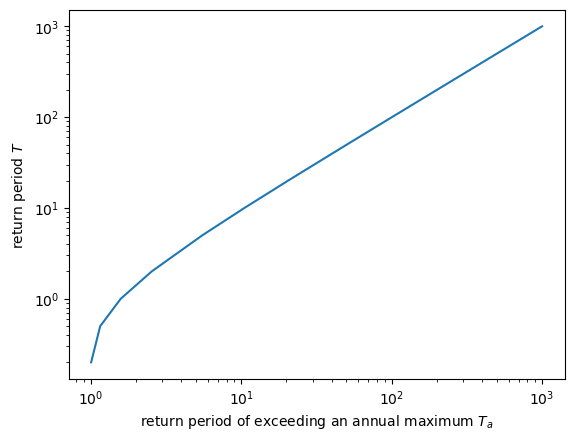

In [41]:
# Here we define the return periods and we inspect the difference between the two return periods
T_interest = np.asarray([0.2, 0.5, 1, 2, 5, 10, 20, 50, 100, 200, 500, 1000])
T_a_interest = 1 / (1-np.exp(-1/T_interest))
plt.loglog(T_a_interest,T_interest)
plt.xlabel('return period of exceeding an annual maximum $T_a$')
plt.ylabel('return period $T$')

# real return period for the observed annual maxima
T_a = 1 / R_max_sorted['p']
R_max_sorted.loc[:,'T_a'] = T_a
T = -1 / np.log(1 - 1/R_max_sorted['T_a'].values) #return periods with GEV
R_max_sorted.loc[:,'T'] = T
R_max_sorted.head(5)

As you can see $T_a$ does not go below 1 and for large return periods the use of $T_a$ or $T$ is not so relevant, hence many people take a shortcut and disregard this difference. Using the array of $T_a$, we can explicitly compute the corresponding Gumbel estimates, by substitution:

${{R}_{\text{Gumbel} }}=\sigma y+\mu $

with:

$y = -\ln(-\ln(q))$

and:

$q = 1 - \frac{1}{T_a}$

giving

${{R}_{\text{Gumbel}}}=\sigma \left( -\ln \left( -\ln (1-\frac{1}{T_a}) \right) \right)+\mu $

further simplifying to

${{R}_{\text{Gumbel}}}=\sigma \left( -\ln (\frac{1}{T}) \right)+\mu $


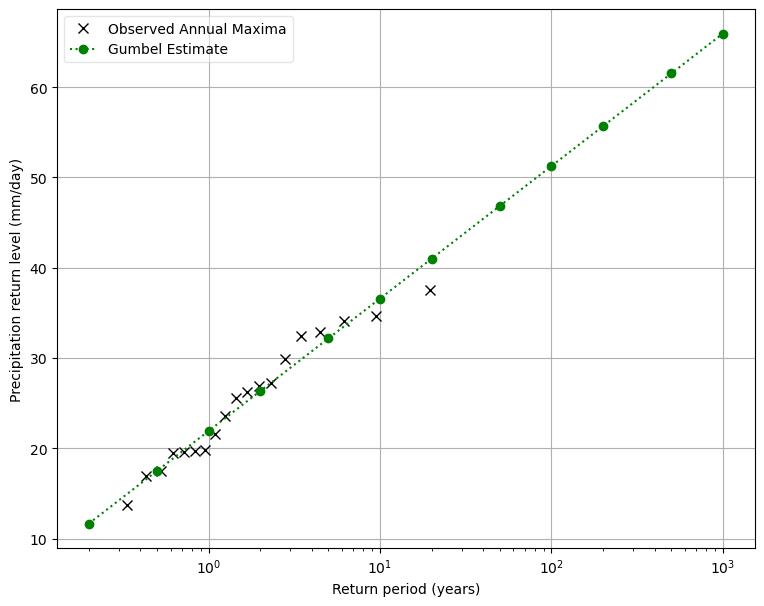

In [42]:
# exercise, Gumbel estimate for return period array T_interest



gumbel_estimate = sigma*(-np.log(1/T_interest)) + mu




# create the figure
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, R_max_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

## 3 GEV
Whereas the Gumbel distribution only has 2 parameters, the GEV distribution has 3 parameters. The cumulative probability that any of the extremes will be less than a given value $x_i$ is given by: 

$F(x;\mu ,\sigma ,\xi )=\left\{ \begin{align}
  & \exp \left( -{{(1+\xi y)}^{\frac{-1}{\xi }}} \right)\text{         }\;\:\:,\xi \ne \text{0 } \\ 
 & \exp \left( -\exp (-y) \right)\text{            }\;\;\;\;\;\;\;,\xi =0 \\ 
\end{align} \right.$

The tail behavior of the different distribution families has been discussed during the lectures. Refer back to this in case you forgot.

In order to compute the GEV we again need the annual maxima series (AMS) for our precipitation data which we already have. 

So, let's estimate the three GEV parameters:

- GEV shape parameter    = $\xi$
- GEV scale parameter    = $\sigma$
- GEV location parameter = $\mu$

The function `mev.gev_fit(AMS)` estimates the GEV parameters automatically based on L-moments.

In [43]:
# fit GEV parameters (withhout overwriting the sigma and mu from Gumbel)
AMS = R_max_sorted['PRCP'].values
xi, sigma_gev, mu_gev = mev.gev_fit(AMS)
xi

-0.17454071601454219

xi less than 0 means reverse Weibull distribution, also known as heavy tailed distribution.

Great, we have the GEV-parameters. However, we are still interested to explicitly compute the precipitation return levels corresponding to the return periods `T_interest` above. Let's check that we still have that variable correctly stored and compute the corresponding cumulative distribution function `F_interest`. Recall, that $F$ equals $q$, which is the probability of not exceeding a certain extreme value. 

$T_a = \frac{1}{p} = \frac{1}{1 - q}$

from which it follows that by substiting the righthandside into the second formula of section 2.1

$F = q = \exp(- \frac{1}{T})$

or going back to the theory from ENVM1400:

$P(\ge 1 \text{ event exceeding } x \text{ in 1 year}) = 1 - P(0 \text{ events exceeding } x \text{ in 1 year})$

thus

$F = q = P(0 \text{ events exceeding } x \text{ in 1 year}) = \exp(- \frac{1}{T})$

In [44]:
# corresponding non-exceedance probabilities
F_interest = np.exp(-(1/T_interest))
# check what you created:
print('T_interest = ' + str(T_interest))
print('F_interest = ' + str(F_interest))


T_interest = [2.e-01 5.e-01 1.e+00 2.e+00 5.e+00 1.e+01 2.e+01 5.e+01 1.e+02 2.e+02
 5.e+02 1.e+03]
F_interest = [0.00673795 0.13533528 0.36787944 0.60653066 0.81873075 0.90483742
 0.95122942 0.98019867 0.99004983 0.99501248 0.998002   0.9990005 ]


Using the function `mev.gev_quant(F, xi, sigma_gev, mu_gev)` we explicitly compute the GEV estimates for our return periods of interest.

In [45]:
# calculate the GEV estimate for our return periods of interest
gev_estimate = mev.gev_quant(F_interest, xi, sigma_gev, mu_gev)

# convert to dataframe and make a nice table
df_gev_estimate = pd.DataFrame(gev_estimate,columns=['GEV estimate (mm/day)'])
df_gev_estimate.index = T_interest # Return Period
df_gev_estimate

,GEV estimate (mm/day)
0.2,9.910568
0.5,17.431467
1.0,22.373033
2.0,26.751506
5.0,31.783371
10.0,35.089531
20.0,38.018953
50.0,41.385528
100.0,43.597519
200.0,45.557452


Now, expand your return level plot that you made for the Gumbel analysis with the GEV estimate. 

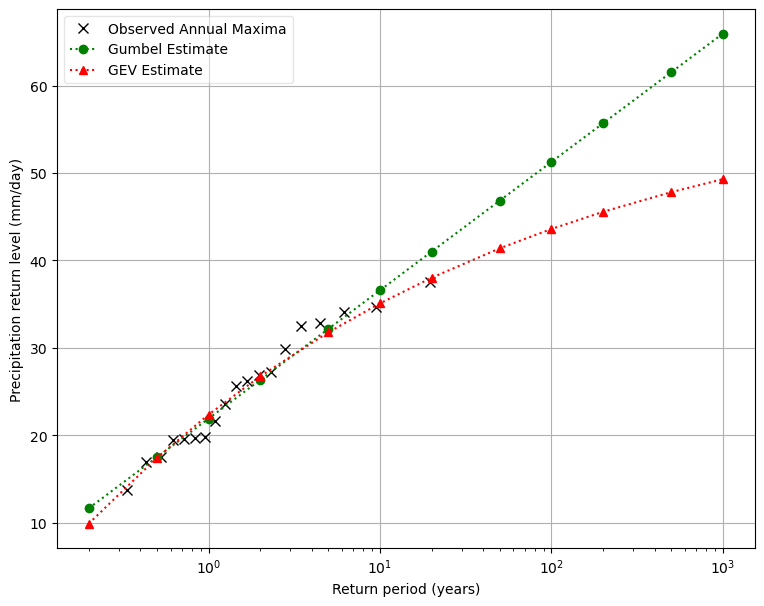

In [46]:
# create the figure
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, R_max_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)

***What do you think of these lines? Does the GEV better fit the data? What do you think of the extrapolation?***

The GEV distribution provides a better fit to the observed data than the Gumbel, as expected. With three parameters (vs. Gumbel’s two), the GEV can adapt to different tail behaviors. Here, the slightly negative shape parameter (ξ = -0.042) indicates a light upper tail, meaning extreme flows are bounded. As a result, the GEV predicts lower extreme quantiles (e.g., 100-year flood) compared to the Gumbel, leading to more conservative risk estimates. 

 

## 4 MEV

MEV stands for Metastatistical Extreme Value distribution. The MEV uses the full distribution of the data, so it also includes the information of the "ordinary" rainfall events to estimate the extremes. The Weibull distribution is fitted to the annual data, whereafter the MEV is computed. 

The MEV-Weibull has the following parameters:

- Dimension of the sample = $N$ ( = number of wet days, i.e. above the threshold of 1 mm/day) 
- Weibull scale parameter = $C$
- Weibull shape parameter = $W$

The function __mev.mev_fit(dataframe, threshold=1)__ estimates the MEV parameters automatically based on Probability Weighthed Moments.

In [47]:
# fit mev parameters for each year
N, C, W =  mev.mev_fit(prec, threshold=1)

# put this into a nice dataframe
df_params_mev = pd.DataFrame([N,C,W]).transpose()
df_params_mev.columns = ['N','C','W']
df_params_mev

,N,C,W
0,81.0,4.698478,1.431428
1,96.0,4.438837,1.254506
2,103.0,4.921655,1.023226
3,107.0,4.945020,1.034986
4,95.0,4.899004,0.965205
5,80.0,3.936972,1.233046
6,95.0,4.855583,1.187729
7,97.0,4.887027,1.150348
8,100.0,5.819078,1.258653
9,90.0,5.512837,1.147676


Let's visualize what we have computed so far. 

For the $N$, $C$ and $W$ parameters that you have just computed, we create histograms like in Figure 1 of in Zorzetto et al. (2016), the top right blue, red and green histograms.

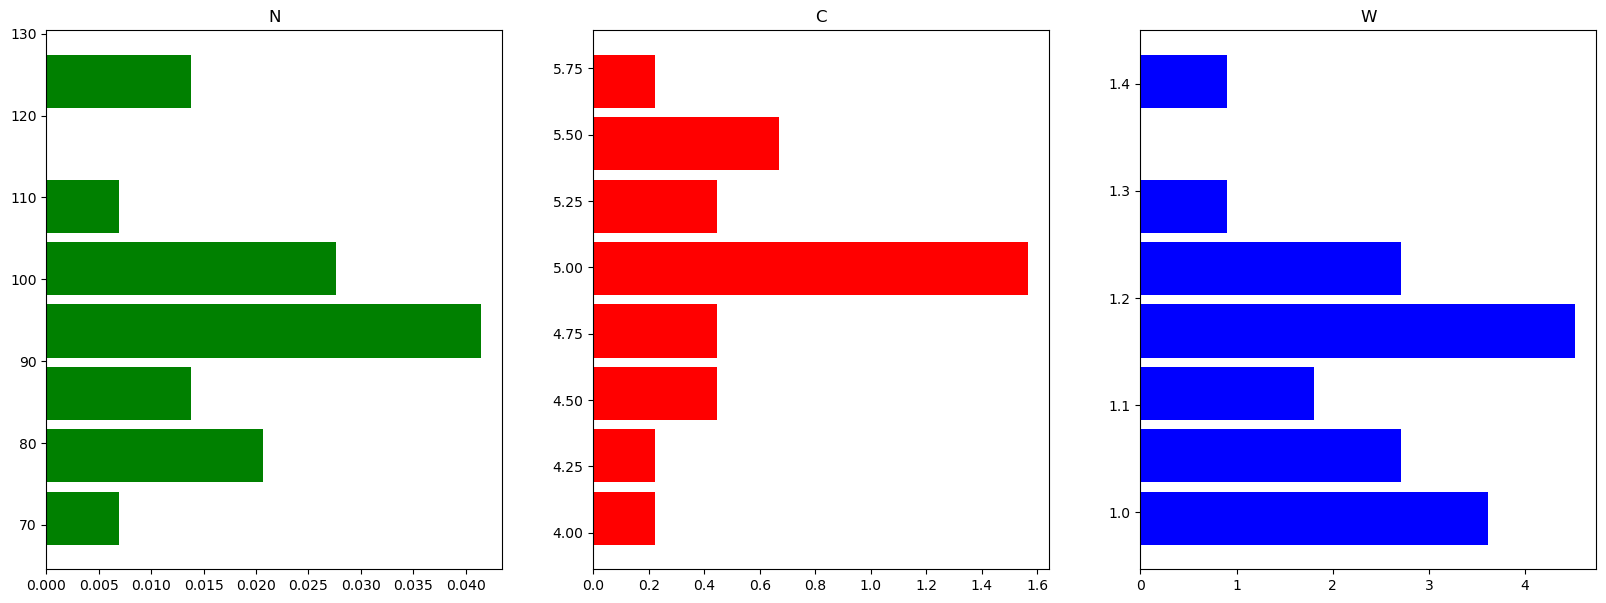

In [48]:
# histograms
params = 'N','C','W'
colors = 'g','r','b'
fig, ax = plt.subplots(1,3, figsize=(20,7))
for a in range(3):
    my_param = params[a]
    my_color = colors[a]
    ax[a].hist(df_params_mev[my_param], rwidth=0.85, density=True, bins=8, 
                                 orientation='horizontal', color=my_color)
    ax[a].set_title(params[a])

In [49]:
len(W)

19

### 4.1 - Exercise: visualize the MEV CDF 
Having the $N$, $C$ and $W$ parameters. For each individual year also plot the cumulative distribution function (CDF). **To do so, first create a table of precipitation versus non-exceedance probability $F$.** A code for plotting is already given in the cell after.

NOTE: there is a typo in Zorzetto et al. (2016). Their Eq. (3) should read: 

$\zeta_m (x) = \frac{1}{M} \sum_{j=1}^{M} \left( 1-\rm{exp}\left[ - \left( \frac{x}{C_j} \right) ^{W_j} \right] \right) ^{N_j}$

The CDF of an individual year is given by:

$H_j (x;C_j,W_j,N_j) = \left( 1-\rm{exp}\left[ - \left( \frac{x}{C_j} \right) ^{W_j} \right] \right) ^{N_j}$


In [50]:
# exercise: create your own code for plotting the CDF curves
dummy_X = np.arange(0,1000,2)

# non-exceedance probability for individual years (here defined as H)
H = np.zeros((len(dummy_X),M))
zeta = np.zeros((len(dummy_X)))

# continue with your own code here:
for i in range(M):  
    H[:,i] = (1-np.exp(-(dummy_X/C[i])**W[i]))**N[i]

for i in range(len(dummy_X)):
    zeta[i] = 1/M*np.sum(H[i,:])





H.shape


(500, 19)

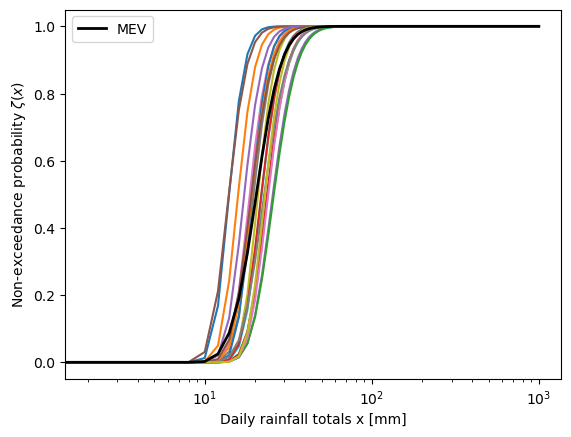

In [51]:
# plot figure like in Enrico's paper
fig, ax = plt.subplots()
ax.plot(dummy_X, H)
ax.plot(dummy_X, zeta, 'k', linewidth=2, label='MEV')
ax.set_xlabel('Daily rainfall totals x [mm]')
ax.set_ylabel('Non-exceedance probability $\zeta(x)$')
ax.set_xscale('log')
ax.legend()

da quel che ho capito H applica i C W N calcolati per i singoli anni di tutto il data base in modo da avere per ogni anno l'exceedance prob calcolata con i vari valori dei paramatri (dummy sono valori random che applichiamo ad ogni anno e ci calcoliamo l'ex prob con i valori dei param trovati). Zeta invece è la media annuale di H.
Da capire qual'è il vantaggio di utilizzare questo metodo.

### 4.2 MEV Estimate
Compute the amounts of precipitation corresponding to the different return periods of interest($T$).

Use the function __mev.mev_quant($q$, $x0$, $N$, $C$, $W$)__ to calculate the MEV estimate. 

Note that the MEV does not have an analytical solution, therefore, we must compute it numerically. The parameter $x0$ is the starting guess for the numerical solution of the MEV. The mean of the annual maxima would be a good initial guess for $x0$. If, however, if the algorithm could not find a solution, an error will be raised and one of the flags will show True. In this case you need to change $x0$.

In [52]:
# exercise, obtain the MEV solution
x0 = np.mean(AMS)
mev_estimate, flags =  mev.mev_quant(F_interest, x0, N, C, W)

if any(flags) == True:
    print('Change starting guess for the numerical solution x0')
elif any(flags) == False:
    print('No errors have been raised, continue the exercise')

No errors have been raised, continue the exercise


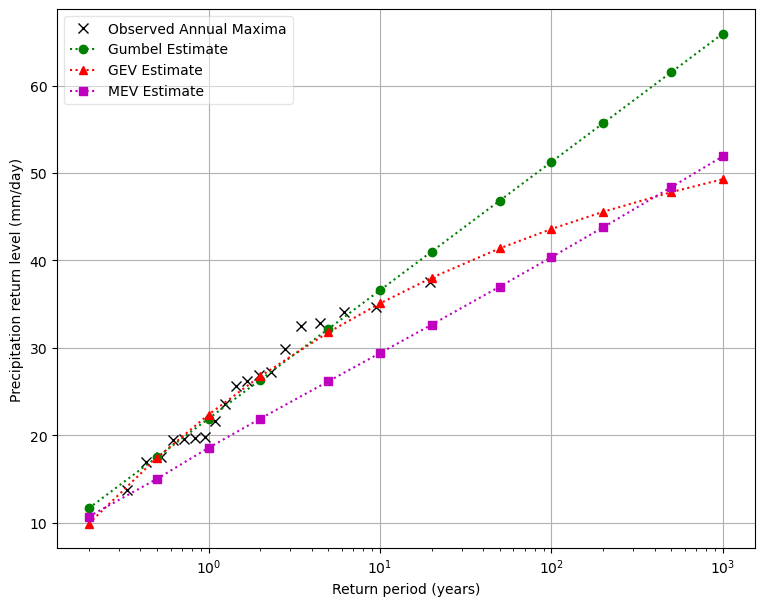

In [53]:
# Now we can expand our plot and compare all EVA methods!
fig, ax = plt.subplots(figsize=(9,7))
ax.plot(T, R_max_sorted['PRCP'].values, \
        'xk', markersize=7, label='Observed Annual Maxima')
ax.plot(T_interest, gumbel_estimate, ':og', label = 'Gumbel Estimate')
ax.plot(T_interest, gev_estimate, ':^r', label='GEV Estimate')
ax.plot(T_interest, mev_estimate, ':sm', label='MEV Estimate')
ax.set_xlabel('Return period (years)')
ax.set_ylabel('Precipitation return level (mm/day)')
ax.set_xscale('log')
ax.legend(loc='best',framealpha=0.5)
ax.grid(True)


## 5 Compare full series, Gumbel, GEV, and MEV

This part of the exercise is not relevant in this case!!!!

## 6 Uncertainty analysis for GEV and MEV
In the plot you made during the previous practical you could see the difference in how the extreme precipitation is estimated using different methods. 

However, it is also important to know how senstive these estimates are. So in order to get an idea of the spread, create a testcase by randomly selecting 10 years of data. Calculate the 100-year return period using both the GEV and MEV distribution. Repeat this 500 times. 

Then make a plot to analyse the spread, for instance by boxplot. Also include the 100-year estimate of the GEV and MEV as calculated before.

Create your code in such a way that you can change the 100-year return period for another one, to see how sensitive the GEV and MEV are for both large and smaller return periods (e.g. 20, 50, 100, 500-years).

### 6.1 - Exercise: write a code for your testcase

In [54]:
# The following code could be used as a starting point:
ntimes     = 500
nyears     = 10
Tx         = 100 # the return period of interest
Fx         = np.exp(-(1/Tx))*(1/Tx)**0  # non-exceedence probability of interest 
                                        #- remember what we did in the beginning of this exercise

# empty variables for the GEV and MEV testcase estimates. 
# also, for the MEV function you need the variable 'flags', for the starting point of the numerial solution
gev_test   = []
mev_test   = []
flags_test = 0

# create a loop that runs ntimes (e.g. a while-loop or a for-loop)
for i in np.arange(ntimes):

    # randomly select nyears from the years in your data. The function 'random.sample' could be used for this
    
    # calculate the GEV estimate for these ten years:
    # 1 - randomly select 10 years from the AMS series created in 2
    AMS_selected = random.sample(AMS.tolist(),nyears)
    # 2 - fit the three GEV parameters
    xi_ntimes,sigma_GEV_ntimes, mu_GEV_ntimes = mev.gev_fit(AMS_selected)
    # 3 - calculate the GEV estimate 
    gev_estimate_i = np.array(mev.gev_quant(Fx, xi_ntimes, sigma_GEV_ntimes, mu_GEV_ntimes))
    # save the gev estimate
    gev_test.append(gev_estimate_i)

    # calculate the MEV estimate for these ten years
    # 1 - randomly select 10 sets of MEV parameters (N,C and W for the same year) created above
    N_selected = random.sample(N.tolist(), nyears)
    C_selected = random.sample(C.tolist(), nyears)
    W_selected = random.sample(W.tolist(), nyears)
    # 2 - give a starting point for the numerical solution (x0). 
    x0 = 0
    # 3 - calculate the MEV estimate: mev, flag = mev.mev_quant(Fx, x0, N, C, W)
    mev_test_i, flag = mev.mev_quant(Fx, x0, np.array(N_selected), np.array(C_selected), np.array(W_selected))



    
    # if no flags have been raised, save the mev estimate
    if flag == True:
        print('A flag has been raised')
        flags_test += 1 # if too many flags have been raised, change the value of x0!
    elif flag == False:
        mev_test.append(mev_test_i)

#### 6.2 - plot the results from your testcase
Create a graph that shows the spread. Examples of such a plot:
- Boxplot
- Figure 4 from Zorzetto et al. (2016)

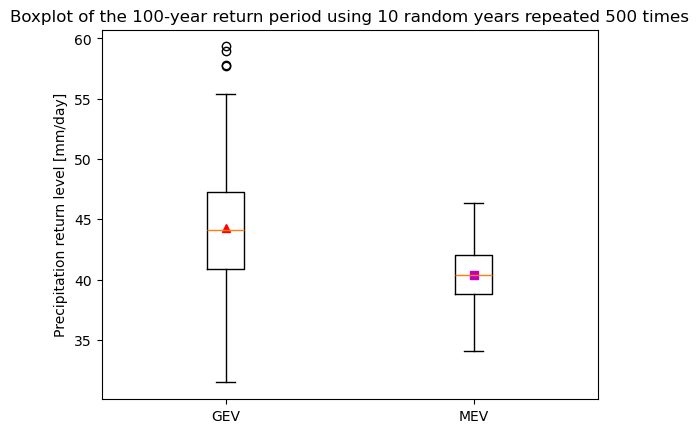

In [55]:
# exercise, plot the results of your testcase
boxplot_data = [gev_test, mev_test]
#print(boxplot_data)
fig, ax = plt.subplots()
ax.boxplot(boxplot_data)
ax.plot(1, np.mean(gev_test), marker='^', color='r', label='GEV mean')
ax.plot(2, np.mean(mev_test), marker='s', color='m', label='MEV mean')
ax.xaxis.set_ticklabels(['GEV', 'MEV'])
ax.yaxis.set_label_text('Precipitation return level [mm/day]')
plt.title('Boxplot of the ' + str(Tx) + '-year return period using ' 
          + str(nyears) + ' random years repeated ' + str(ntimes) + ' times')
plt.show()

The narrower box of MEV suggests lower variability and more stable estimates. MEV also appears more conservative as the median values is lower than the one of GEV. 

### 7 Exercise: reflective questions
1. Is GEV a better method than Gumbel? Explain your answer. 

The Generalized Extreme Value (GEV) distribution offers a more robust framework for modeling extreme events compared to the Gumbel distribution, primarily due to its flexible three-parameter structure. While the Gumbel distribution serves as a special case of GEV when the shape parameter ξ equals zero, this very restriction limits its applicability. The GEV's shape parameter provides critical information about tail behaviour: negative values reveal bounded upper limits typical of regulated systems, and near-zero values approximate Gumbel's exponential decay. 

In this case ξ = -0.042, GEV appropriately accounts for the light-tailed behavior, yielding more conservative and physically realistic extreme value estimates than the Gumbel distribution would produce. 

 

2. In which cases does the MEV provide an advantage over the GEV? 

The Mean Extreme Value (MEV) method outperforms conventional approaches in four critical scenarios: (1) with short records (<30 years), where its multi-year pooling reduces uncertainty; (2) under non-stationary conditions (e.g., climate trends), where ensemble averaging improves robustness; (3) when parameter uncertainty matters, as MEV integrates distributional information rather than point estimates; and (4) computationally, where MEV's solver handles skewed data more reliably than GEV. These advantages result in the boxplot's narrower MEV interquartile range, demonstrating superior estimation stability. 

 

3. Which method of all methods do you think gives the most reliable estimate for precipitation that belongs to the 5 year return period? 

For estimating 5-year return period precipitation, the Gumbel distribution offers an optimal balance of simplicity and accuracy. Its two-parameter structure provides sufficient flexibility for modeling moderate extremes while avoiding the overfitting risks associated with more complex distributions. The exponential tail behavior of the Gumbel distribution aligns well with typical rainfall characteristics at this timescale, making it particularly suitable for frequent events. Since 5-year precipitation events occur relatively often, even limited observational records (typically 10-20 years) yield reliable estimates. The method's computational efficiency and straightforward interpretation further reinforce its practical advantages for this application. 

 

4. Which method of all methods do you think gives the most reliable estimate 

for precipitation that belongs to the 1000 year return period? 

For estimating 1000-year return period precipitation, the Mean Extreme Value (MEV) method is generally preferred as it provides more stable estimates by combining information across multiple years. The Generalized Extreme Value (GEV) distribution serves as a viable alternative when the data exhibits clear heavy-tailed behavior (ξ > 0). However, all methods involve substantial uncertainty when extrapolating to such rare events. 

 